# Transformación de datos

Importante: NO EJECUTAR

El programa actual trabaja sobre un entorno de Cloud Computing donde los datos se almacenan en la nube. Ejecutar el trabajo actual conduciría
a error, puesto que no se encontrará las tablas mencionadas.

En este entorno Cloud, el lenguaje base al leer ficheros desde el Lakehouse es Spark.

Los nombres de las tablas y columnas se modifican directamente sobre el Lakehouse, utilizando Power Query.

El resultado de este programa son dos "Delta Tables" que se sobreescriben con los datos mas recientes cada vez que 
se ejecuta el Notebook.

La tabla Spread_PVPc contiene los valores máximo, mínimo y medio diarios para el PVPc desde el 1 de enero de 2023. Además, incluye el cálculo del Spread como la resta entre el valor máximo y mínimo registrado cada día.

La tabla Bar_Spread_PVPc contiene los valores del spread en lo que llevamos de año y sus valores de la misma fecha un año atras.


In [2]:
import pandas as pd


#Cargamos como spark
spark_df = spark.sql("SELECT * FROM REE_Lakehouse.ID_1001_2023_NoEnd_AVG")
display(spark_df)

#Pasamos a pandas
df = spark_df.toPandas()


StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 4, Finished, Available)

SynapseWidget(Synapse.DataFrame, ac03637b-ace3-40cf-ab18-fcb194691998)

In [3]:
#Comprobamos que se ha cargado correctamente como DataFrame
df.head()

StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 5, Finished, Available)

,indicator_name,indicator_id,magnitud,frecuency,updated_date,PVPc_value,datetime,datetime_utc,geo_id,geo_name
0,Término de facturación de energía activa del P...,1001,Precio,Hora,2024-03-10T20:46:54.000+01:00,43.01,2023-01-01T01:00:00.000+01:00,2023-01-01T00:00:00Z,8741,Península
1,Término de facturación de energía activa del P...,1001,Precio,Hora,2024-03-10T20:46:54.000+01:00,58.07,2023-01-01T02:00:00.000+01:00,2023-01-01T01:00:00Z,8741,Península
2,Término de facturación de energía activa del P...,1001,Precio,Hora,2024-03-10T20:46:54.000+01:00,60.69,2023-01-01T03:00:00.000+01:00,2023-01-01T02:00:00Z,8741,Península
3,Término de facturación de energía activa del P...,1001,Precio,Hora,2024-03-10T20:46:54.000+01:00,62.91,2023-01-01T04:00:00.000+01:00,2023-01-01T03:00:00Z,8741,Península
4,Término de facturación de energía activa del P...,1001,Precio,Hora,2024-03-10T20:46:54.000+01:00,61.48,2023-01-01T05:00:00.000+01:00,2023-01-01T04:00:00Z,8741,Península


In [4]:
#Comprobamos el dtype de las variables
df.info()

StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 6, Finished, Available)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10451 entries, 0 to 10450
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   indicator_name  10451 non-null  object 
 1   indicator_id    10451 non-null  int64  
 2   magnitud        10451 non-null  object 
 3   frecuency       10451 non-null  object 
 4   updated_date    10451 non-null  object 
 5   PVPc_value      10451 non-null  float64
 6   datetime        10451 non-null  object 
 7   datetime_utc    10451 non-null  object 
 8   geo_id          10451 non-null  int64  
 9   geo_name        10451 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 816.6+ KB


In [5]:
#Creamos una variable truncando la variable tipo object, "datetime" en un datetime
df['n_datetime'] = pd.to_datetime(df.datetime, utc = True)

# Al establecer como indice cambiaria de nuevo el tipo a "index", asi que no podemos usar set_index.

# Cambiamos el indice diciendo directamente que ese nuevo indice en un datetime
df.index = pd.DatetimeIndex(df.n_datetime)

StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 7, Finished, Available)

In [6]:
# df con los valores maximos y minimos para calcular el spread de precios. Valor medio para estudiar su progresión.
df3 = df.resample('1D')['PVPc_value'].agg([('max_value', 'max'), ('min_value', 'min'), ('mean_value', 'mean')])
df3.round(2)

StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 8, Finished, Available)

,max_value,min_value,mean_value
n_datetime,,,
2023-01-01 00:00:00+00:00,123.50,43.01,64.73
2023-01-02 00:00:00+00:00,302.19,104.45,201.81
2023-01-03 00:00:00+00:00,298.14,175.74,225.21
2023-01-04 00:00:00+00:00,300.19,142.74,200.21
2023-01-05 00:00:00+00:00,314.57,118.39,194.89
...,...,...,...
2024-03-07 00:00:00+00:00,156.16,49.53,86.30
2024-03-08 00:00:00+00:00,125.15,44.98,80.58
2024-03-09 00:00:00+00:00,49.34,41.94,44.63


In [7]:
# Creamos una tercera columna con la diferencia
df3['spread_PVPc'] = df3['max_value'] - df3['min_value']
df3

StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 9, Finished, Available)

,max_value,min_value,mean_value,spread_PVPc
n_datetime,,,,
2023-01-01 00:00:00+00:00,123.50,43.01,64.731667,80.49
2023-01-02 00:00:00+00:00,302.19,104.45,201.814167,197.74
2023-01-03 00:00:00+00:00,298.14,175.74,225.212917,122.40
2023-01-04 00:00:00+00:00,300.19,142.74,200.205833,157.45
2023-01-05 00:00:00+00:00,314.57,118.39,194.890833,196.18
...,...,...,...,...
2024-03-07 00:00:00+00:00,156.16,49.53,86.297500,106.63
2024-03-08 00:00:00+00:00,125.15,44.98,80.576667,80.17
2024-03-09 00:00:00+00:00,49.34,41.94,44.627500,7.40


StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 10, Finished, Available)

<Axes: title={'center': 'Evolucion Spread PVPc España'}, xlabel='fecha', ylabel='Spread_precio'>

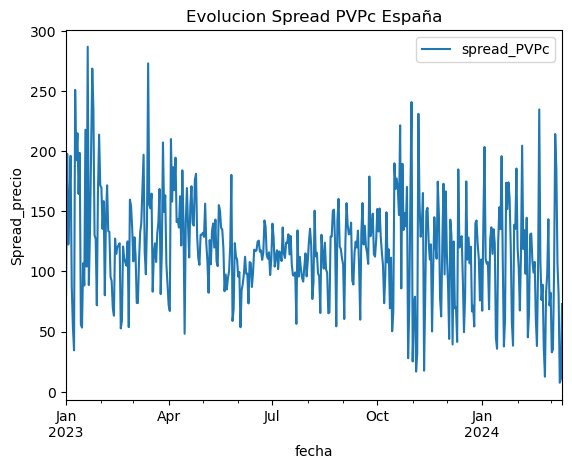

In [8]:
# Comprobamos nuestros datos con un gráfico de líneas
import matplotlib.pyplot as plt

df3.plot(kind = 'line', y = 'spread_PVPc', title = 'Evolucion Spread PVPc España', xlabel = 'fecha', ylabel = 'Spread_precio')

In [9]:
# Reseteamos el índice para obtener la fecha como columna antes de pasar a Delta Table.
df3.reset_index(inplace = True)
df3

StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 11, Finished, Available)

,n_datetime,max_value,min_value,mean_value,spread_PVPc
0,2023-01-01 00:00:00+00:00,123.50,43.01,64.731667,80.49
1,2023-01-02 00:00:00+00:00,302.19,104.45,201.814167,197.74
2,2023-01-03 00:00:00+00:00,298.14,175.74,225.212917,122.40
3,2023-01-04 00:00:00+00:00,300.19,142.74,200.205833,157.45
4,2023-01-05 00:00:00+00:00,314.57,118.39,194.890833,196.18
...,...,...,...,...,...
431,2024-03-07 00:00:00+00:00,156.16,49.53,86.297500,106.63
432,2024-03-08 00:00:00+00:00,125.15,44.98,80.576667,80.17
433,2024-03-09 00:00:00+00:00,49.34,41.94,44.627500,7.40
434,2024-03-10 00:00:00+00:00,51.41,40.91,47.511667,10.50


In [20]:
#Creamos las lista sobre las que albergar nuestros resultados del bucle
lista_spread_2024 = []
lista_spread_2023 = []
fecha_formato = []

# Modificamos nuesta varible "n_datetime" para eliminar la información de zona horaria
df3['n_datetime'] = df3['n_datetime'].dt.tz_localize(None)

# Creamos un objeto con la fecha de hoy como Timestamp
fecha_hoy = pd.Timestamp.today()

# Restar un año a la fecha de hoy. Lo usaremos en el bucle for. En caso de error, restamos 366 días dado que los datos de origen se actualizan una vez al día.
fecha_hace_un_año = fecha_hoy - pd.Timedelta(days=365)

# Itera sobre las filas del DataFrame
for index, row in df3.iterrows():
    # si la fecha en la fila actual es posterior al 1 de enero de 2024
    if row['n_datetime'] >= pd.Timestamp("2024-01-01"):
        # Agrega el valor de 'spread_PVPc' correspondiente a la lista
        lista_spread_2024.append(row['spread_PVPc'])
        fecha_formato.append(row['n_datetime'])
    # si la fecha de la fila es menor que la fecha actual un año atras
    if row['n_datetime'] < fecha_hace_un_año:
        # Agrega el valor de 'spread_PVPc' correspondiente a la lista
        lista_spread_2023.append(row['spread_PVPc'])

print(lista_spread_2024)
print(lista_spread_2023)


len(lista_spread_2024)

StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 22, Finished, Available)

[67.3, 140.41000000000003, 203.48000000000002, 110.24000000000001, 106.31, 107.65, 68.58, 126.65, 136.66000000000003, 114.53, 135.08999999999997, 123.11, 44.40999999999998, 35.64999999999999, 124.71000000000001, 153.37, 135.16, 195.87, 109.60000000000001, 37.53999999999999, 59.61999999999999, 173.76, 151.85, 174.07999999999998, 161.40000000000003, 121.18999999999998, 57.56999999999999, 38.2, 138.77999999999997, 135.39, 185.54000000000002, 120.11999999999999, 103.0, 67.47999999999999, 115.44, 204.57999999999998, 118.58000000000001, 134.22, 97.99000000000001, 144.59, 45.18999999999999, 64.04, 130.69, 131.5, 108.64, 99.11, 107.88, 60.209999999999994, 37.95, 104.28, 234.73000000000002, 108.73, 76.20000000000002, 88.93, 36.03, 12.409999999999997, 82.43, 97.64000000000001, 143.4, 71.69, 82.24000000000001, 32.7, 35.07, 98.32, 214.28, 185.5, 106.63, 80.17000000000002, 7.400000000000006, 10.5, 72.88000000000001]
[80.49000000000001, 197.74, 122.39999999999998, 157.45, 196.18, 87.17999999999999, 

71

In [21]:
len(lista_spread_2023)

StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 23, Finished, Available)

71

In [22]:
# Creamos el df a partir de las listas obtenidas.
df_comp = pd.DataFrame({'Fecha' : fecha_formato, 'Spread_2024' : lista_spread_2024, 'Spread_2023' : lista_spread_2023})
df_comp


StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 24, Finished, Available)

,Fecha,Spread_2024,Spread_2023
0,2024-01-01,67.30,80.49
1,2024-01-02,140.41,197.74
2,2024-01-03,203.48,122.40
3,2024-01-04,110.24,157.45
4,2024-01-05,106.31,196.18
...,...,...,...
66,2024-03-07,106.63,140.41
67,2024-03-08,80.17,169.64
68,2024-03-09,7.40,197.09
69,2024-03-10,10.50,115.70


In [23]:
# Transformamos mi pandas df en un spark df para guardarlo como Delta Table
sp_df = spark.createDataFrame(df3)

# Nombramos nuesta tabla
table_name = "Spread_PVPc"

#Creamos una Delta Table desde nuestro Spark_df. Especificamos que se sobreescriba cada vez que se ejecute.
sp_df.write.mode("overwrite").format("delta").option("overwriteSchema", "true").save(f"Tables/{table_name}")

# Confirmamos la carga como Delta Table
print(f"DataFrame has been written to Delta table: {table_name}")

StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 25, Finished, Available)

DataFrame has been written to Delta table: Spread_PVPc


In [24]:
# Transformamos el df_comp en spark df para guardarlo como Delta Table.
sp_df_comp = spark.createDataFrame(df_comp)

# Nombramos nuesta tabla
table_name_2 = "Bar_Spread_PVPc"

# Creamos una Delta Table desde nuestro Spark_df. Especificamos que se sobreescriba cada vez que se ejecute.
sp_df_comp.write.mode("overwrite").format("delta").option("overwriteSchema", "true").save(f"Tables/{table_name_2}")

# Confirmamos la carga como Delta Table
print(f"DataFrame has been written to Delta table: {table_name_2}")

StatementMeta(, 4c8f5ae0-decb-4099-b310-1d06f01ca61b, 26, Finished, Available)

DataFrame has been written to Delta table: Bar_Spread_PVPc
